# Math 607 HW 2
### Sean Ericson 4/30/2024

In [1]:
# Imports
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import combinations
from functools import reduce
from IPython.display import display, Math, Latex, HTML, clear_output

mpl.rcParams['figure.dpi'] = 125
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,physics}'
%matplotlib inline

In [2]:
#Some code that implements progress bars for long computations
#https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
bar_length = 20
def update_progress(progress):
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Shot Noise
### 1)

The function "Simulate_Neuron" takes as arguments the total number of iterations (i.e. the number of simulations), the time to simulate for, the input activation rate, and the sample spacing for values of $Y(t)$. The function returns the times at which $Y(t)$ (a list with about total_time/sample_spacing entries), the $Y(t)$ samples, and the means and variances of those samples. 

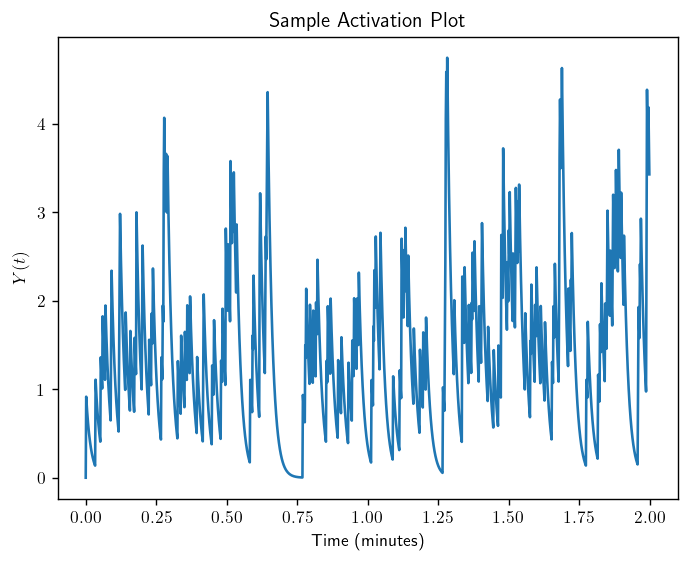

In [3]:
def Simulate_Neuron(N_iter, total_time, input_rate, sample_spacing, show_progress=False):
    sample_times = np.arange(0, total_time, sample_spacing)

    Ys = []
    for iter in range(N_iter):
        N_activations = np.random.poisson(input_rate*total_time)
        activation_times = np.random.uniform(0, total_time, N_activations)
        Y = [sum([np.exp(-(t - s)*60) for s in activation_times if s <= t]) for t in sample_times]
        Ys.append(Y)
        if show_progress:
            update_progress((iter + 1) / N_iter)

    Ys = np.array(Ys)
    means = np.mean(Ys, axis=0)
    vars = np.var(Ys, axis=0)
    return (sample_times, Ys, means, vars)

total_time = 2 # 2 minute total simulation
λ = 100 # Input rate
sample_spacing = 0.1 * 1/60 # 10 Hz sample rate

ts, ys, _, _ = Simulate_Neuron(1, total_time, λ, sample_spacing)
plt.plot(ts, ys[0])
plt.xlabel("Time (minutes)")
plt.ylabel("$Y(t)$")
plt.title("Sample Activation Plot")
plt.show()

### 2)

By the linearity of the expectation value,
$$
\begin{align*}
    \mathbb{E}[Y(t)] &= \mathbb{E}[\sum_k e^{-(t - s_k)}] \\
    &= \sum_k \mathbb{E}[e^{-(t - s_k)}] \\
    &= \mathbb{E}[N_k]\int_0^t e^{-t'} \text{d}t' \\
    &= \lambda \left(1 - e^{-t}\right).
\end{align*}
$$
Since the integral was calculated in terms of seconds, we need to express the rate in units of inverse seconds, i.e 5/3 per second. Then, the expectation value is
$$ \mathbb{E}[Y(t)] = \frac{5}{3}(1 - e^{-t}). $$
Similarly, the variance is given by
$$
\begin{align*}
    \text{Var}[Y(t)] &= \text{Var}[\sum_k e^{-(t - s_k)}] \\
    &= \sum_k \text{Var}[e^{-(t - s_k)}] \\
    &= \mathbb{E}[N_k]\int_0^t e^{-2t'} \text{d}t' \\
    &= \frac{\lambda}{2}(1 - e^{-2t}) \\
    &= \frac{5}{6}(1-e^{-2t})
\end{align*}
$$

The code below uses the Simulate_Neuron function to perform 1000 simulations of $Y(t)$. The mean and variance over time is the plotted.

Progress: [####################] 100.0%


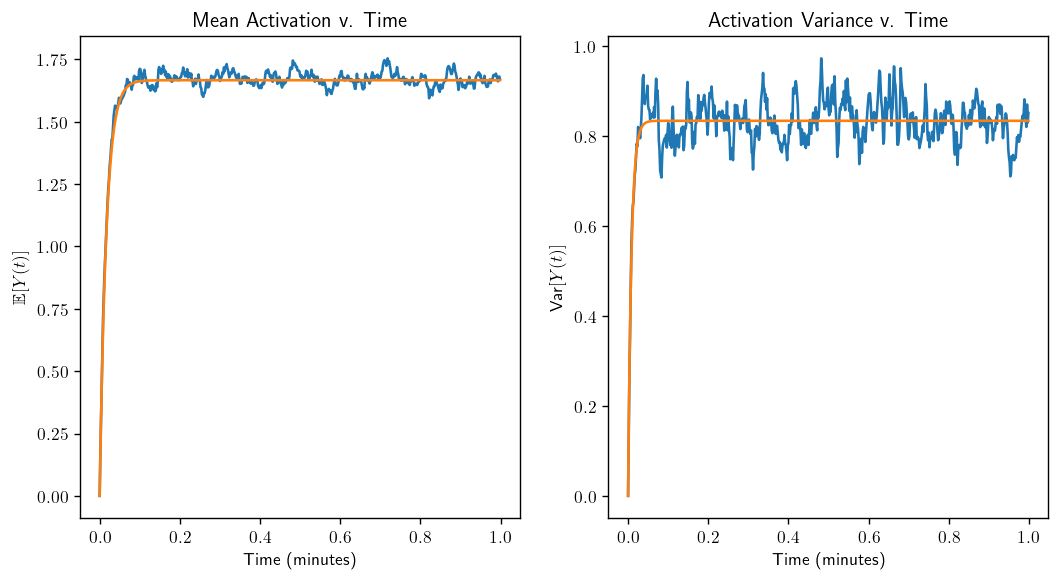

In [4]:
# Simulate 1000 times
N_iter = 1000
total_time = 1 # 1 minute total simulation
λ = 100 # Input rate
sample_spacing = 0.1 * 1/60 # 10 Hz sample rate
ts, _, mean, var = Simulate_Neuron(N_iter, total_time, λ, sample_spacing, show_progress=True)

calculated_mean = [5*(1 - np.exp(-t*60))/3 for t in ts]
calculated_var = [5*(1 - np.exp(-2*t*60))/6 for t in ts]

fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Plot means
ax[0].plot(ts, mean)
ax[0].plot(ts, calculated_mean)
ax[0].set_xlabel("Time (minutes)")
ax[0].set_ylabel(r"$\mathbb{E}[Y(t)]$")
ax[0].set_title("Mean Activation v. Time")

# Plot var
ax[1].plot(ts, var)
ax[1].plot(ts, calculated_var)
ax[1].set_xlabel("Time (minutes)")
ax[1].set_ylabel(r"$\text{Var}[Y(t)]$")
ax[1].set_title("Activation Variance v. Time")
plt.show()

## Brownian Motion
### 1)

The function "BrownianWalk" defined bellow implements Brownian motion as the scaled limit of a Brownian walk. It takes as arguments the total time duration of the walk and the number of steps of the walk. It returns the times for each step, and the position of the walk at those times.

In [5]:
def BrownianWalk(end_time, total_steps):
    steps = np.random.randint(0, 2, total_steps)*2 -1
    times = np.linspace(0, end_time, total_steps+1)
    positions = [sum(steps[:i])/np.sqrt(total_steps) for i in range(len(steps) + 1)]
    return (times, positions)

In the code bellow, the function BrownianWalk is used to simulate 1000 Brownian paths. Each path is saved and plotted. The functions $f(t) = \pm\sqrt{t}$ are included for reference.

Progress: [####################] 100.0%


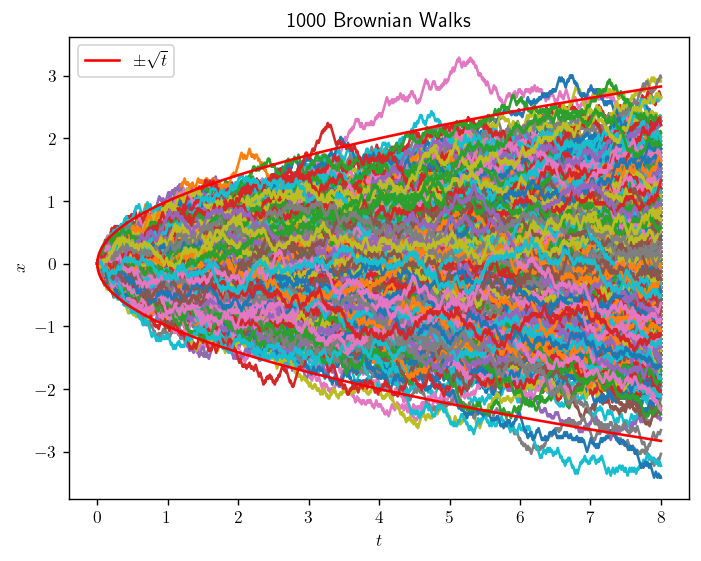

In [6]:
N_paths = 1000
N_steps = 1000
time = 8
paths = []
for i in range(N_paths):
    ts, xs = BrownianWalk(time, N_steps)
    paths.append(xs)
    plt.plot(ts, xs)
    update_progress((i+1)/N_paths)

sqrt = np.sqrt(ts)
plt.plot(ts, sqrt, 'r')
plt.plot(ts, -sqrt, 'r', label=r"$\pm\sqrt{t}$")
plt.title("{} Brownian Walks".format(N_paths))
plt.ylabel("$x$")
plt.xlabel("$t$")
plt.legend()
plt.show()

## 2)

From the simulated paths above, the distribution of positions at times $t \in \{0.5, 1, 2, 4, 8\}$ are plotted. They are compared to the normal distributions $B_t \sim N(0, t)$. The agreement is abysmal, and I'm not sure if that's due to an issue with the way I'm simulating the paths, or a problem with the way the matplotlib histogram function is scaling the bars =/.

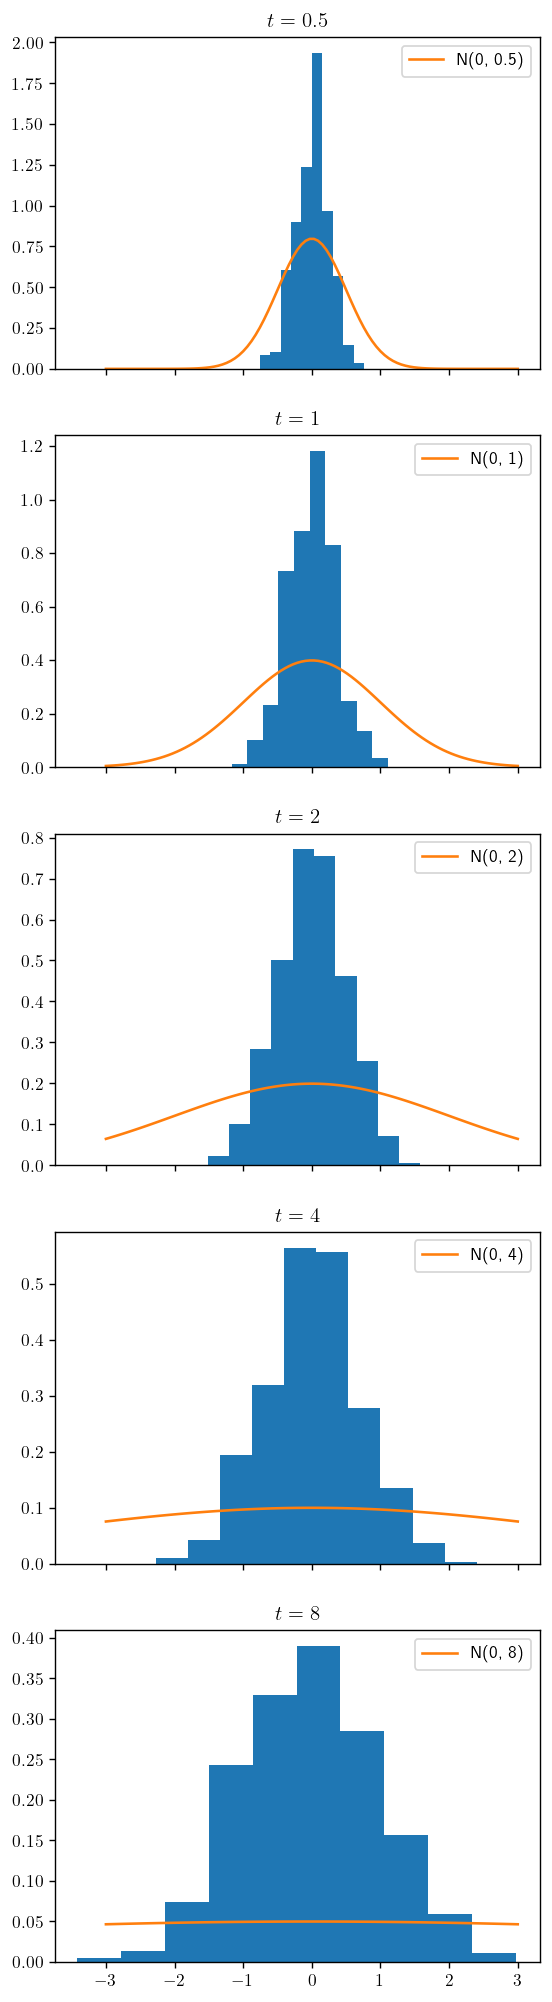

In [7]:
sample_times = [0.5, 1, 2, 4, 8]
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(5, 20))
for index, t in enumerate(sample_times):
    # Get positions at time t
    sample_positions = [path[int(t*N_steps/time)] for path in paths]

    # Plot histogram of positions
    ax[index].hist(sample_positions, density=True)

    # plot the PDF of the centered normal w/ std dev t
    xs = np.linspace(-3, 3, 100)
    ax[index].plot(xs, scipy.stats.norm.pdf(xs, 0, t), label=r"N(0, {})".format(t))
    ax[index].legend()

    # Title the subplot w/ the time
    ax[index].set_title("$t = {}$".format(t))

## 3)

The function "hits_a_before_b" defined bellow takes as arguments a brownian path, a positive number a and a negative number b. It returns true if the path hits a before b, and false if it hits b before a. If the path hits neither a nor b, the function throws an error.

In [8]:
def hits_a_before_b(path, a, b):
    # a > 0, b < 0
    for x in path:
       if x >= a:
           return True
       if x <= b:
           return False
    raise Exception("Neither {} nor {} hit by the path".format(a, b))

In the code bellow, I use the function defined above to plot the proportion of paths that hit $x$ before -1 for $0<x\leq 1$. Since we're only simulating paths for a finite amount of time, there is a finite probability that any given path does not hit -1 or 1 in the simulated time. I could just simulate for long enough that this probability is sufficiently low, but I think it's easier to just only consider only the already simulated paths that both cross 0 and 1. With enough simulated paths, this shouldn't bias the statistics too much.

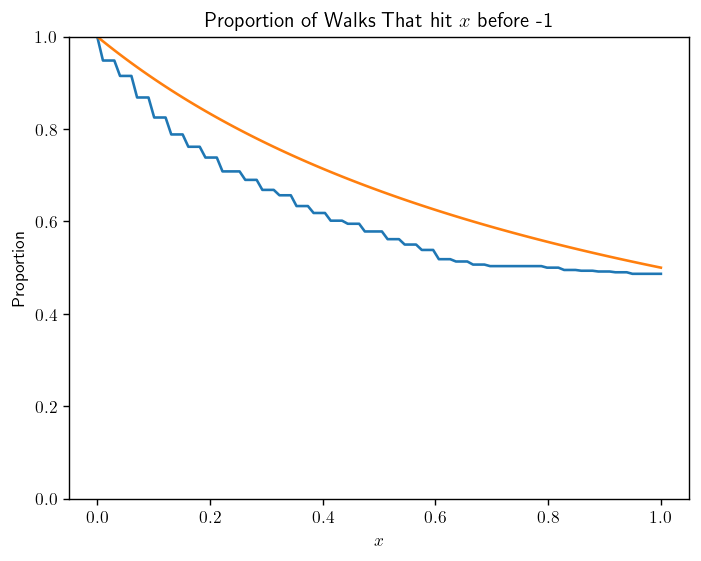

In [9]:
xs = np.linspace(0, 1, 100)
good_paths = []
for path in paths:
    try:
        hits_a_before_b(path, 1, -1)
        good_paths.append(path)
    except:
        pass
    
props = [len([_ for path in good_paths if hits_a_before_b(path, x, -1)]) / len(good_paths) for x in xs]
foo = [1 / (1 + x) for x in xs]
plt.plot(xs, props)
plt.plot(xs, foo)
plt.ylabel("Proportion")
plt.xlabel("$x$")
plt.title("Proportion of Walks That hit $x$ before -1")
plt.ylim(0,1)
plt.show()

The proportion appears to approach 0.5, as expected by symmetry: the paths are random and start at 0 so their just as likely to hit 1 and -1 and any given time. Based on some googling, it seems like the distribution should be $\frac{1}{x + 1}$, which makes sense and doesn't agree with my plot, so I think I need to either generate more paths, or there must be something wrong with my code.

## Gaussian Horizions
### 1)

The function "sample_horizon" samples the $N$-dimensional multivariate distribution described in the question. The "size" parameter controls how many samples are returned. A sample horizon with $N=50$ is plotted.

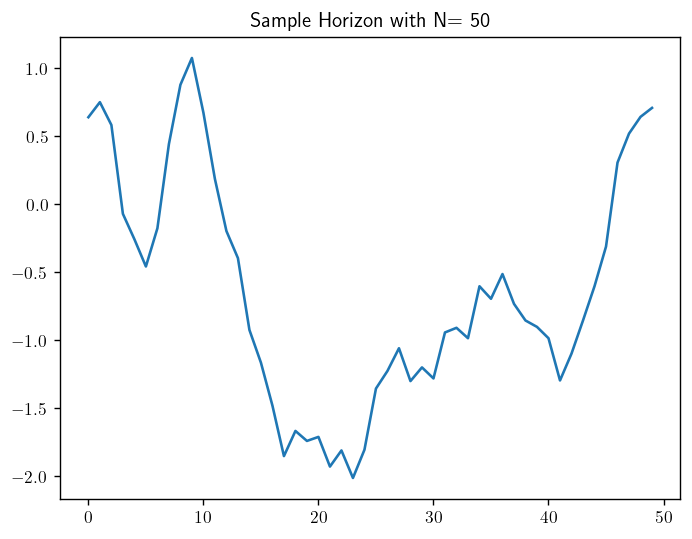

In [10]:
def sample_horizon(N, size=1):
    mean = np.zeros(N)
    cov = np.diag([1.01]*N)
    for i,j in combinations(list(range(N)), 2):
        if i == j:
            cov[i,i] = 1.01
        else:
            dist = min(abs(i-j), N-abs(i-j))
            cov_ij = 1 / (1 + (10*dist/N)**2)
            cov[i,j] = cov_ij
            cov[j,i] = cov_ij
            
    return scipy.stats.multivariate_normal.rvs(mean, cov, size=size)

N = 50
xs = list(range(N))
horizon = sample_horizon(N)
plt.plot(xs, horizon)
plt.title("Sample Horizon with N= {}".format(N))
plt.show()

The code below plots 16 different samples of the multivariate normal with values of $N$ evenly spaced between 50 and 500.

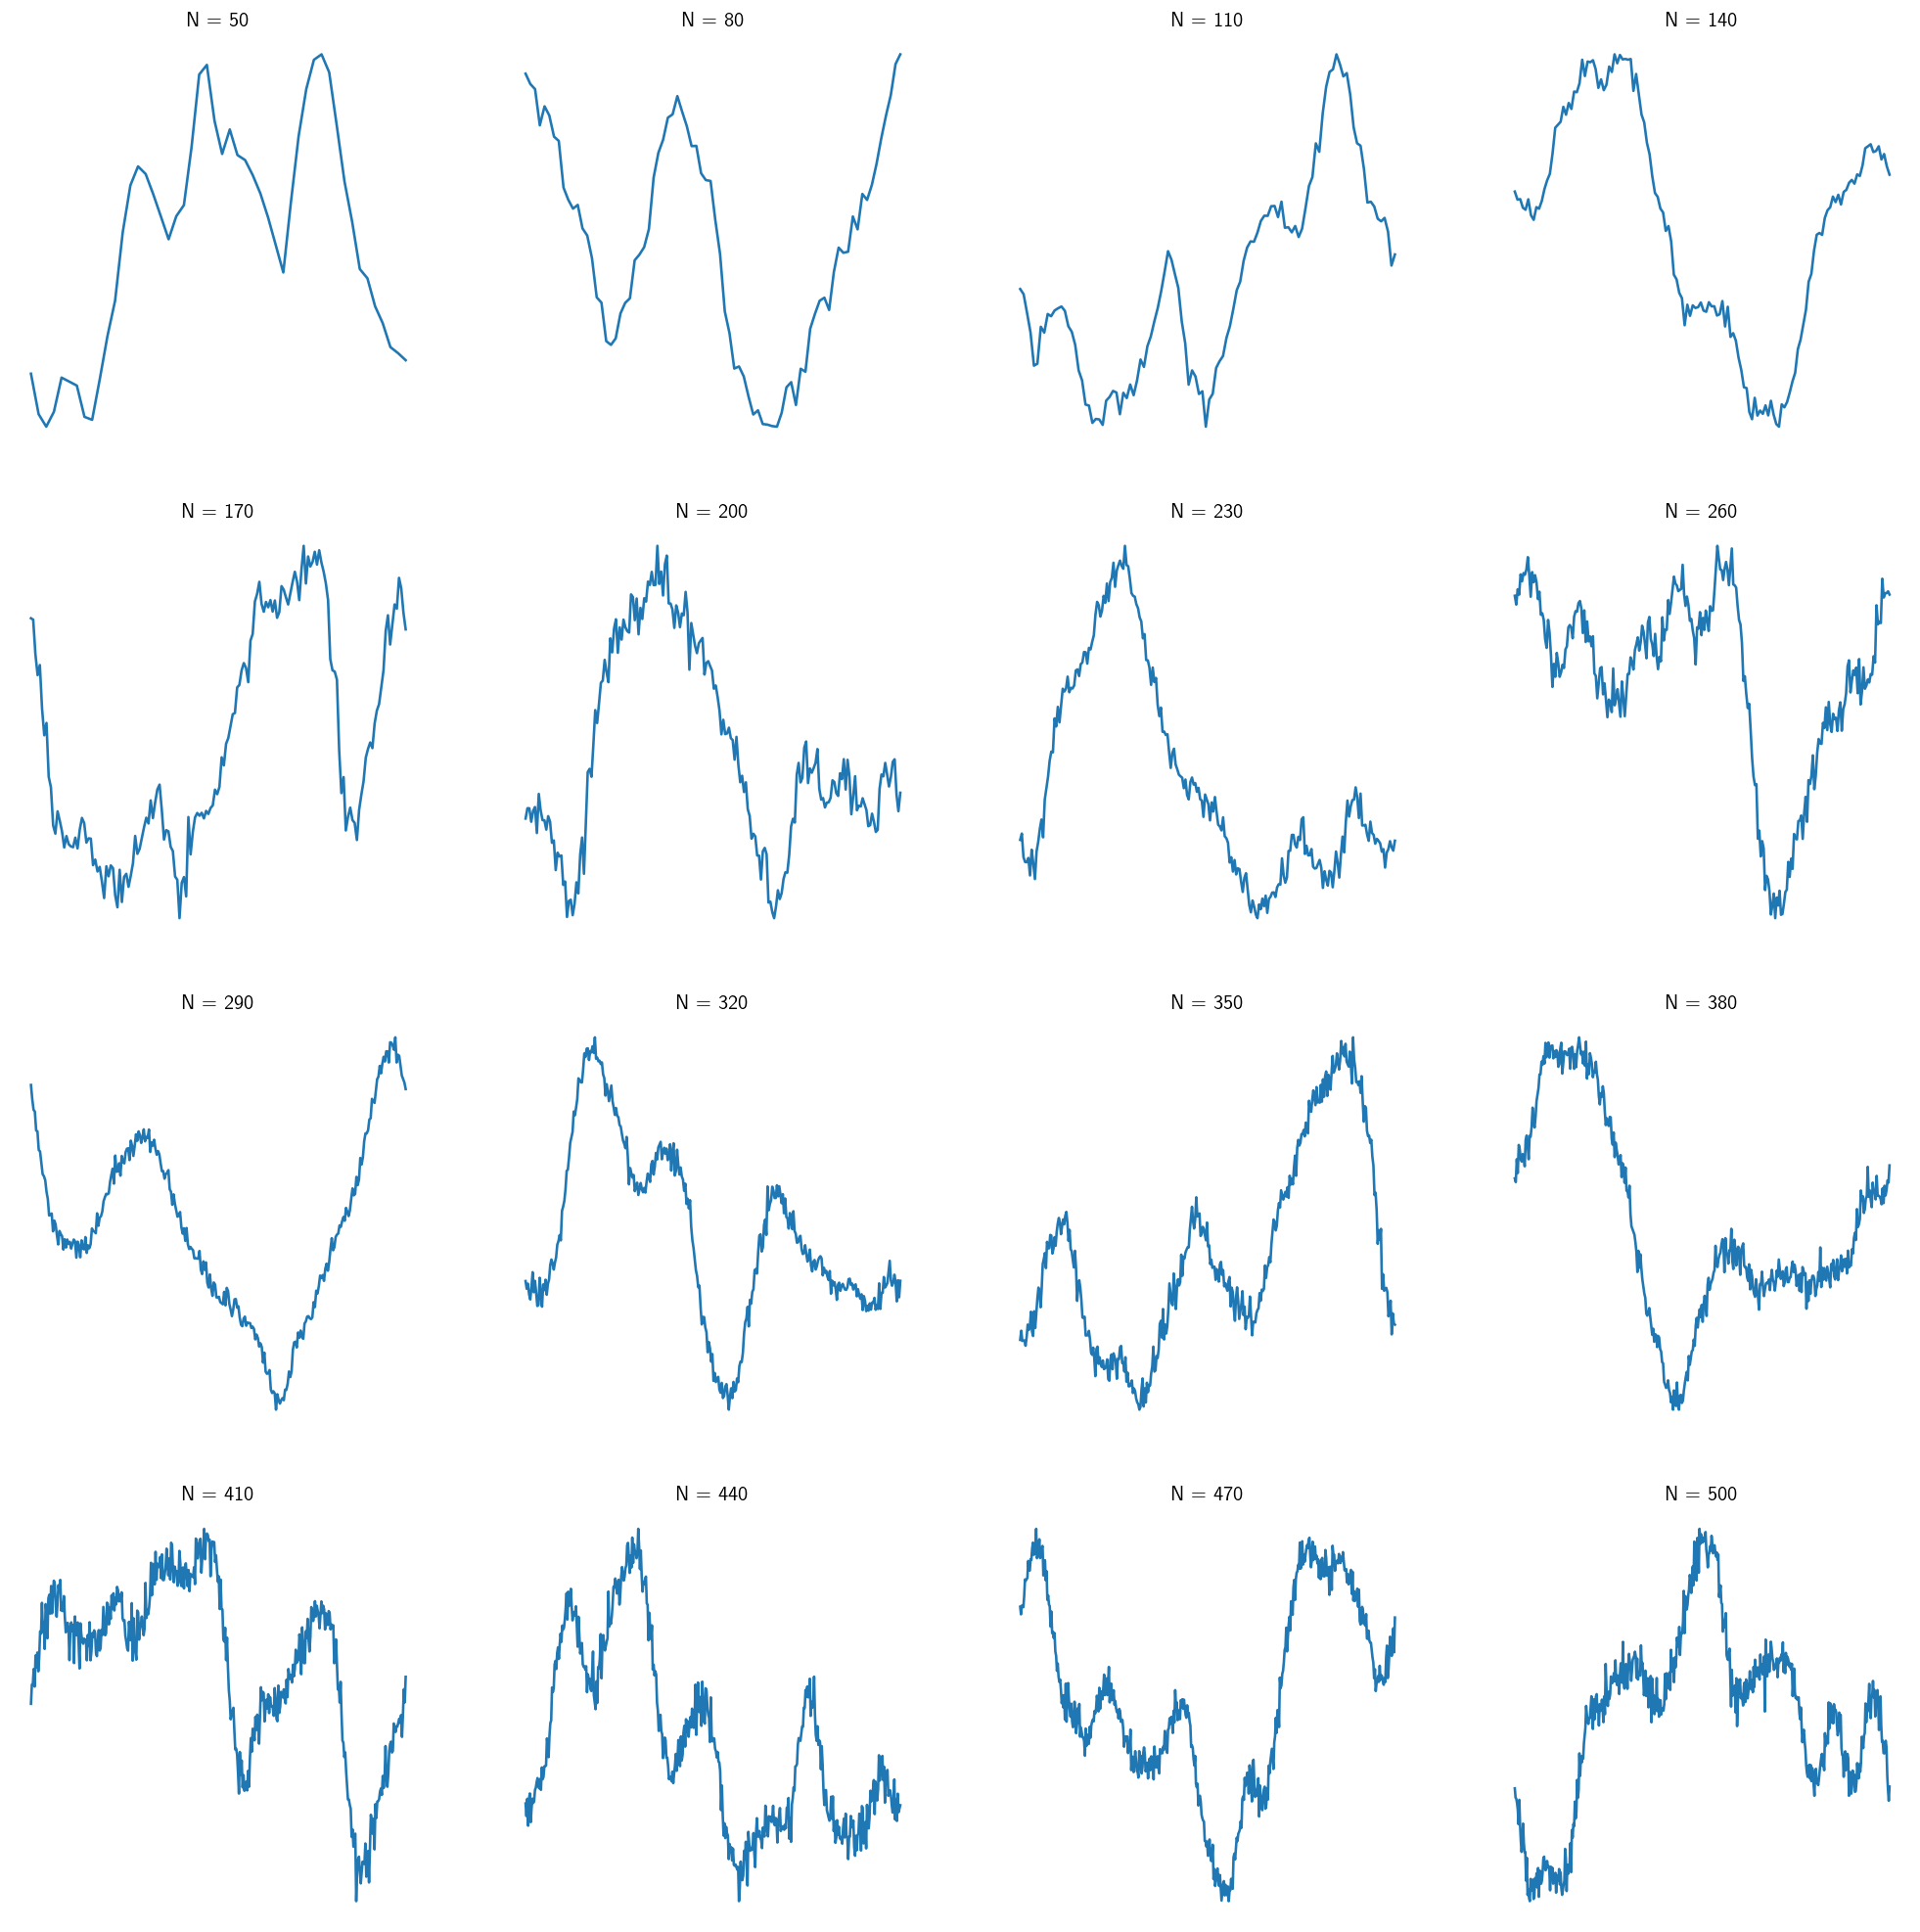

In [11]:
fig, ax = plt.subplots(4, 4, figsize=(20,20))
sample_Ns = np.linspace(50, 500, 16, dtype=int)
for i, N in enumerate(sample_Ns):
    axis = ax[i // 4][i % 4]
    
    xs = list(range(N))
    horizon = sample_horizon(N)
    
    axis.plot(xs, horizon)
    axis.axis("off")
    axis.set_title("N = {}".format(N))


### 2)

The function below implements the "U(s, t)$ function described in problem. For a given horizon, it calculates $U(s, t)$ for that horizon.

In [12]:
def U(horizon, s, t):
    N = len(horizon)
    return sum(horizon[int(s*N):int(t*N)+1]) / (N * (t-s))

The code below samples 10000 $N=50$ horizons, and calculates $U(0, t)$ for 20 values of $t$ evenly spaced between 0.1 and 1. It then calculates $\text{Cov}[U(0, t), U(0, s)]$

In [13]:
N = 50
N_horizon_samples = 10000
N_st_samples = 20
st_samples = np.linspace(0.1, 1, N_st_samples)
horizons = sample_horizon(N, size=N_horizon_samples)
U_samples = np.array([[U(horizon, 0, t) for t in st_samples] for horizon in horizons])
cov = np.cov(U_samples.T)

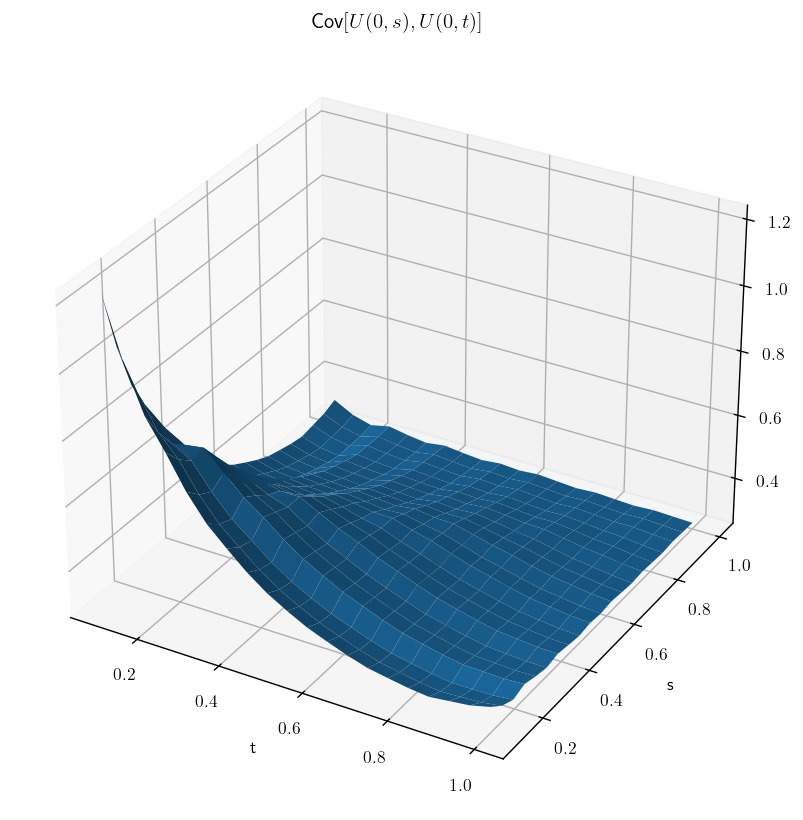

In [14]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(st_samples, st_samples)

ax.plot_surface(X, Y, cov)
ax.set_xlabel('t')
ax.set_ylabel('s')
plt.title("$\\text{Cov}[U(0,s), U(0, t)]$")
plt.show()

I'm not sure about an expression for this covariance, but I expect it should actually only depend on $s-t$, which the plot above seems to agree with.

In [15]:
N = 510
N_horizon_samples = 10000
N_st_samples = 20
st_samples = np.linspace(0.1, 1, N_st_samples)
horizons = sample_horizon(N, size=N_horizon_samples)
U_samples = np.array([[U(horizon, 0, t) for t in st_samples] for horizon in horizons])
cov = np.cov(U_samples.T)

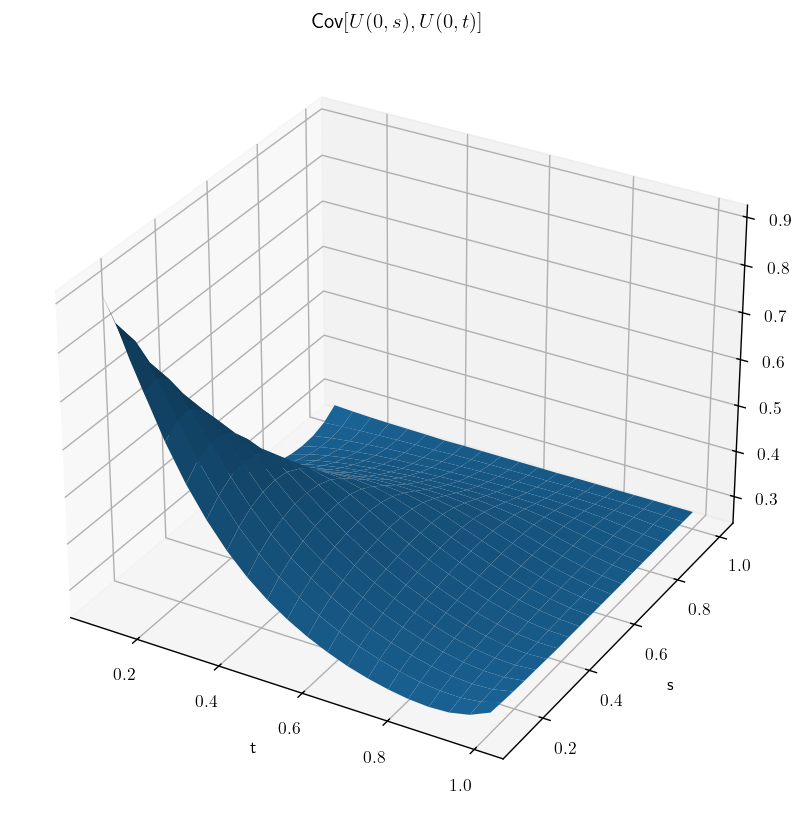

In [16]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(st_samples, st_samples)

ax.plot_surface(X, Y, cov)
ax.set_xlabel('t')
ax.set_ylabel('s')
plt.title("$\\text{Cov}[U(0,s), U(0, t)]$")
plt.show()